# Zillow House Value Investigation

## Imports

In [1]:
#tabular data imports :
import pandas as pd
import numpy as np
import env
from env import user, password, host
from pydataset import data

# visualization imports:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
# success metrics from earlier in the week: mean squared error and r^2 explained variance
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

from scipy.stats import pearsonr, spearmanr
from scipy.stats import shapiro

import warnings
warnings.filterwarnings("ignore")
import wrangle as w
import os
directory = os.getcwd()

# Data Dictionary


| Feature | Definition |
|:--------|:-----------|
| id | Unique identifier for a property record |
| bedroomcnt, bedrooms | The number of bedrooms in the property |
| bathroomcnt, bathrooms | The number of bathrooms in the property, including partial bathrooms |
| calculatedfinishedsquarefeet, sqft | The total square footage of the property as calculated from public records |
| yearbuilt | The year the property was originally constructed |
| fips, county | Federal Information Processing Standards code representing the county in which the property is located |
| latitude | The latitude coordinate of the property |
| longitude | The longitude coordinate of the property |
| transactiondate, transaction_date | The date the property transaction was recorded |
| propertylandusedesc, property_class | The type or use of land the property is classified under |
| taxvaluedollarcnt, **taxvalue** | The total tax assessed value of the property |
| percentile_rank  | The percentile rank of the property based on the house square feet |



## Acquire
#### - Data acquired from the CodeUp mySQL server, the zillow database was gathered during the Tobias cohort.
#### - Size of data ((65418 rows, 13 columns)
#### - SQL query that imports the data focuses on non-nulls
#### - Each row represents a single family home transaction
#### - Each column represents a feature for the transaction

## Zillow data

In [2]:
df_zillow = w.get_zillow_data()
df_zillow.head(3)

,id,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,yearbuilt,fips,latitude,longitude,transactiondate,propertylandusedesc,taxvaluedollarcnt,percentile_rank
0,5692,3.0,1.0,706.0,1922.0,6037.0,34117963.0,-118200539.0,2017-01-26,Single Family Residential,133437.0,0.010042
1,6551,2.0,1.0,706.0,1921.0,6037.0,33979340.0,-118292988.0,2017-01-30,Single Family Residential,26831.0,0.010042
2,63323,2.0,1.0,706.0,1922.0,6037.0,33914931.0,-118348347.0,2017-08-02,Single Family Residential,134631.0,0.010042


In [3]:
df_zillow.shape

(57091, 12)

In [4]:
df_zillow.isnull().sum()

id                              0
bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
yearbuilt                       0
fips                            0
latitude                        0
longitude                       0
transactiondate                 0
propertylandusedesc             0
taxvaluedollarcnt               4
percentile_rank                 0
dtype: int64

In [5]:
df_zillow.describe().T

,count,mean,std,min,25%,50%,75%,max
id,57091.0,3.863084e+04,22340.926137,2.000000e+01,1.956150e+04,3.864500e+04,5.711850e+04,7.761100e+04
bedroomcnt,57091.0,3.342839e+00,0.925804,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,1.100000e+01
bathroomcnt,57091.0,2.240738e+00,0.900315,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,9.000000e+00
calculatedfinishedsquarefeet,57091.0,1.835880e+03,773.586565,7.060000e+02,1.280000e+03,1.642000e+03,2.204000e+03,5.227000e+03
yearbuilt,57091.0,1.960278e+03,22.146708,1.808000e+03,1.949000e+03,1.958000e+03,1.974000e+03,2.016000e+03
fips,57091.0,6.048309e+03,20.837299,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
latitude,57091.0,3.401557e+07,245421.197210,3.334071e+07,3.384037e+07,3.401481e+07,3.417740e+07,3.480695e+07
longitude,57091.0,-1.182066e+08,345269.400601,-1.194484e+08,-1.183954e+08,-1.181690e+08,-1.179566e+08,-1.175559e+08
taxvaluedollarcnt,57087.0,4.273027e+05,443225.600779,7.584000e+03,1.885260e+05,3.271140e+05,5.230000e+05,1.472112e+07
percentile_rank,57091.0,4.997549e-01,0.282995,1.004154e-02,2.543170e-01,4.998455e-01,7.448934e-01,9.899928e-01


# Prepare
#### Prepare

- perform univariate stats
- clean up data
- encode data
- split data

### Prepare Actions:

- Removed columns that did not contain useful information
- Renamed columns to promote readability
- Checked for nulls in the data (there were none)
- Checked that column data types were appropriate
- Added additional features to investigate:
    - rm_X_sqft
- Compare categorical variables
- Split data into train(60), validate(20) and test(20) (no stratifying)
- Scale continuous variable
- Outliers within 1% of max or min of square feet (sqft) have been removed for this iteration of the project

In [6]:
df = w.prep_zillow(w.get_zillow_data())
df.head(3)

,id,bedrooms,bathrooms,sqft,yearbuilt,county,latitude,longitude,transaction_date,property_class,taxvalue,percentile_rank
0,5692,3,1.0,706,1922,LA,34117963.0,-118200539.0,2017-01-26,Single Family Residential,133437,0.010042
1,6551,2,1.0,706,1921,LA,33979340.0,-118292988.0,2017-01-30,Single Family Residential,26831,0.010042
2,63323,2,1.0,706,1922,LA,33914931.0,-118348347.0,2017-08-02,Single Family Residential,134631,0.010042


In [7]:
df = df.set_index('id')
df.drop(['percentile_rank'], axis=1, inplace=True)
df.head(3)

,bedrooms,bathrooms,sqft,yearbuilt,county,latitude,longitude,transaction_date,property_class,taxvalue
id,,,,,,,,,,
5692,3,1.0,706,1922,LA,34117963.0,-118200539.0,2017-01-26,Single Family Residential,133437
6551,2,1.0,706,1921,LA,33979340.0,-118292988.0,2017-01-30,Single Family Residential,26831
63323,2,1.0,706,1922,LA,33914931.0,-118348347.0,2017-08-02,Single Family Residential,134631


In [8]:
df['rm_X_sqft'] = round((df['bathrooms'] + df['bedrooms'])/df['sqft'], 6)
df.head(3)

,bedrooms,bathrooms,sqft,yearbuilt,county,latitude,longitude,transaction_date,property_class,taxvalue,rm_X_sqft
id,,,,,,,,,,,
5692,3,1.0,706,1922,LA,34117963.0,-118200539.0,2017-01-26,Single Family Residential,133437,0.005666
6551,2,1.0,706,1921,LA,33979340.0,-118292988.0,2017-01-30,Single Family Residential,26831,0.004249
63323,2,1.0,706,1922,LA,33914931.0,-118348347.0,2017-08-02,Single Family Residential,134631,0.004249


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57087 entries, 5692 to 54760
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bedrooms          57087 non-null  int64  
 1   bathrooms         57087 non-null  float64
 2   sqft              57087 non-null  int64  
 3   yearbuilt         57087 non-null  int64  
 4   county            57087 non-null  object 
 5   latitude          57087 non-null  float64
 6   longitude         57087 non-null  float64
 7   transaction_date  57087 non-null  object 
 8   property_class    57087 non-null  object 
 9   taxvalue          57087 non-null  int64  
 10  rm_X_sqft         57087 non-null  float64
dtypes: float64(4), int64(4), object(3)
memory usage: 5.2+ MB


In [10]:
df.shape

(57087, 11)

In [11]:
df.isnull().sum()

bedrooms            0
bathrooms           0
sqft                0
yearbuilt           0
county              0
latitude            0
longitude           0
transaction_date    0
property_class      0
taxvalue            0
rm_X_sqft           0
dtype: int64

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,57087.0,3.342845e+00,0.925792,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,1.100000e+01
bathrooms,57087.0,2.240773e+00,0.900330,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,9.000000e+00
sqft,57087.0,1.835896e+03,773.600710,7.060000e+02,1.280000e+03,1.642000e+03,2.204000e+03,5.227000e+03
yearbuilt,57087.0,1.960279e+03,22.146337,1.808000e+03,1.949000e+03,1.958000e+03,1.974000e+03,2.016000e+03
latitude,57087.0,3.401557e+07,245428.340160,3.334071e+07,3.384037e+07,3.401483e+07,3.417740e+07,3.480695e+07
longitude,57087.0,-1.182066e+08,345266.277351,-1.194484e+08,-1.183954e+08,-1.181690e+08,-1.179566e+08,-1.175559e+08
taxvalue,57087.0,4.273027e+05,443225.600779,7.584000e+03,1.885260e+05,3.271140e+05,5.230000e+05,1.472112e+07
rm_X_sqft,57087.0,3.233203e-03,0.000733,5.780000e-04,2.699000e-03,3.203000e-03,3.731000e-03,1.059600e-02


In [13]:
pd.crosstab(df.property_class, df.county)

county,LA,Orange,Ventura
property_class,,,
"Duplex (2 Units, Any Combination)",2542,12,7
Single Family Residential,36186,13700,4640


In [14]:
df.county.value_counts(normalize=True)

LA         0.678403
Orange     0.240195
Ventura    0.081402
Name: county, dtype: float64

# Explore

### Univariate Analysis pre-scaling

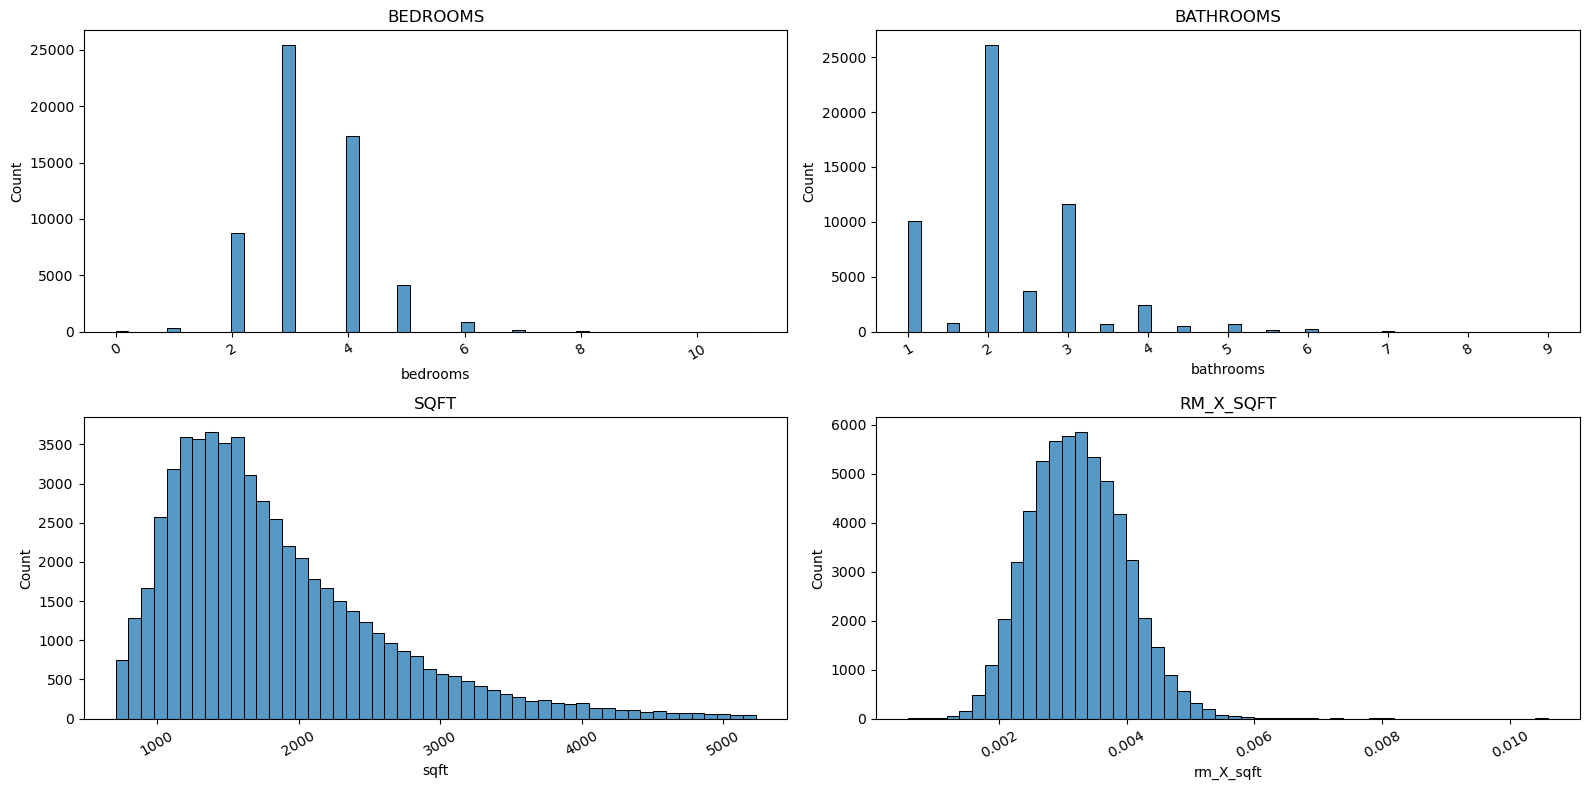

In [15]:
cols = ['bedrooms', 'bathrooms', 'sqft', 'rm_X_sqft']

# Determine the number of rows needed for subplots
n_rows = len(cols) // 2 + len(cols) % 2
fig, axes = plt.subplots(n_rows, 2, figsize=(16, n_rows*4))

for i, col in enumerate(cols):
    ax = axes.flatten()[i]
    sns.histplot(df[col], bins=50, ax=ax)  # Using seaborn for a more refined look
    ax.set_title(col.upper(), fontsize=12)  # Set title for each subplot
    ax.tick_params(axis='x', rotation=30)   # Rotate x-axis labels
    ax.grid(False)  # Hide gridlines

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


## Spliting

#### NOTES:
- only using NON-NULLs
- removed 1% of top and bottom (2% total) values using the feature ranking 'sqft' as to remove possible human error in istances where '0' or an exaggerated number was imputed for the 'sqft' feature.
- I created a feature (column) named 'rm_X_sqft' as a result of dividing ('bedrooms' and 'bathrooms') by 'sqft'

In [16]:
train, validate, test = w.split_data(df)


    train -> (34252, 11)
    validate -> (11417, 11)
    test -> (11418, 11)


In [17]:
# scale that data!
# separate X and y!
X_train, y_train = train.drop(columns=['taxvalue','county','transaction_date', 'property_class']), train['taxvalue']
X_validate, y_validate = validate.drop(columns=['taxvalue','county','transaction_date', 'property_class']), validate['taxvalue']
X_test, y_test = test.drop(columns=['taxvalue','county','transaction_date', 'property_class']), test['taxvalue']

## Hypotheses:

### Q1. Is there a relationship between sqft and taxvalue?

- both of my variables are continuous

- check for correlation

$H_0$: There is no linear correlation between sqft and taxvalue

$H_a$: There is a linear correlation between sqft and taxvalue

In [18]:
zillow_corr = train.corr(method='spearman')

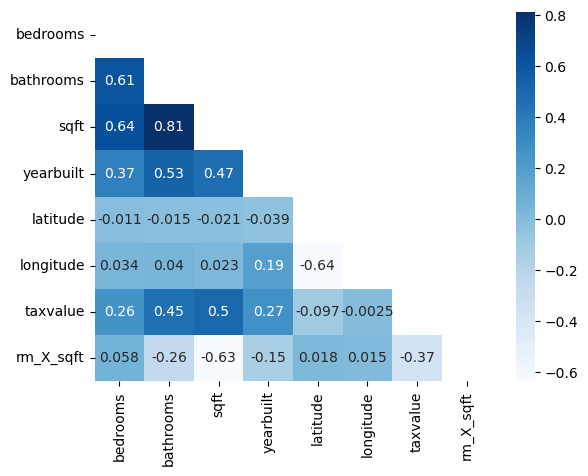

In [19]:
# pass my correlation matrix to Seaborn's heatmap with customization
sns.heatmap(zillow_corr, cmap='Blues', annot=True, 
            mask=np.triu(zillow_corr))
plt.show()

In [20]:
# Variables are not normally distributed
# using scipy stats function spearmanr to calculate correlation and p-value 
r, p = spearmanr(train.sqft, train.taxvalue)
w.eval_Spearman(r,p)

We reject H₀, there is a monotonic relationship.
Spearman’s r: 0.501131
P-value: 0.0


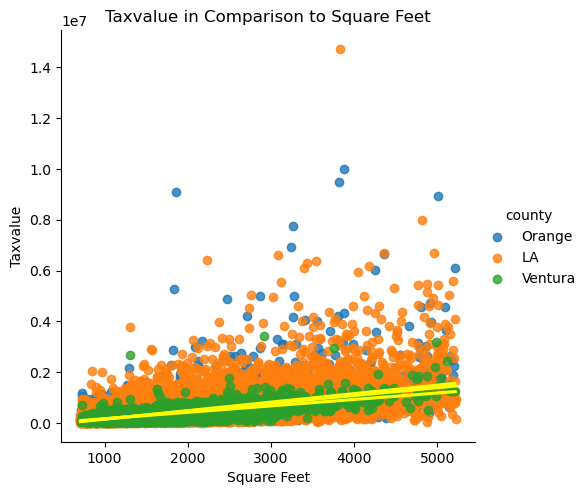

In [21]:
# Using sns to plot the correlation between taxvalue and sqft, with a hue of county and a best fit line for each county
sns.lmplot(data=train, x='sqft', y='taxvalue', markers='o',
           line_kws={'color':'yellow'},aspect=1,hue='county')
plt.title('Taxvalue in Comparison to Square Feet')
plt.xlabel('Square Feet')
plt.ylabel('Taxvalue')
plt.show()

### the SpearmanR test shows there is a monotonic relationship between sqft and taxvalue

### There seems to be a great correlation between sqft and taxvalue, as sqft increases, taxvalue also increases.  Which makes sense as the larger the constructed house, themore material it takes to be built, therefore more expensive. 

## Hypotheses:

### Q2. Is there a relationship between number of bedrooms and taxvalue?

- both of my variables are continuous

- check for correlation

$H_0$: There is no linear correlation between number of bedrooms and taxvalue

$H_a$: There is a linear correlation between number of bedrooms and taxvalue

In [22]:
# using scipy stats function spearmanr to calculate correlation and p-value 
r, p = spearmanr(train.bedrooms, train.taxvalue)
w.eval_Spearman(r,p)

We reject H₀, there is a monotonic relationship.
Spearman’s r: 0.260175
P-value: 0.0


### the SpearmanR test shows there is a monotonic relationship between number of bedrooms and taxvalue

### There seems to be a great correlation between number of bedrooms and taxvalue, as the number of bedrooms increases (up to 5) the value increases, after 5, the taxvalue is less reflected on number of bedrooms. 

## Hypotheses:

### Q3. Is there a relationship between number of bathrooms and taxvalue?

- both of my variables are continuous

- check for correlation

$H_0$: There is no linear correlation between number of bathrooms and taxvalue

$H_a$: There is a linear correlation between number of bathrooms and taxvalue

In [23]:
# Since my variables are not normally distributed, 
# use scipy stats function spearmanr to calculate correlation and p-value 
r, p = spearmanr(train.bathrooms, train.taxvalue)
w.eval_Spearman(r,p)

We reject H₀, there is a monotonic relationship.
Spearman’s r: 0.453905
P-value: 0.0


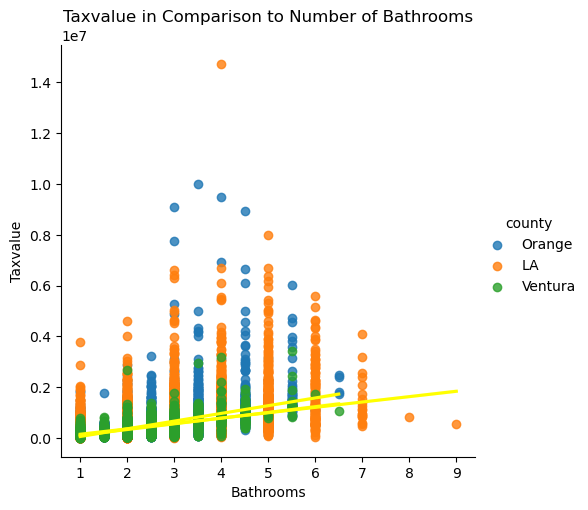

In [24]:
# I can really pop that line color if I want
sns.lmplot(data=train, x='bathrooms', y='taxvalue',hue='county',
           line_kws={'color':'yellow'})
plt.title('Taxvalue in Comparison to Number of Bathrooms')
plt.xlabel('Bathrooms')
plt.ylabel('Taxvalue')
plt.show()

sns.boxplot(x='bathrooms', y='taxvalue', data=train)

plt.show()

### the SpearmanR test shows there is a monotonic relationship between number of bathrooms and taxvalue

### There seems to be a great correlation between number of bathrooms and taxvalue, as the number of bathrooms increases (up to 6.5) the value increases, after 7, the taxvalue is less reflected on number of bathrooms. 

## You may use this as a template for how to ask and answer each question:

## Exploration Summary
* SpearmanR test shows a **monotonic relationship between sqft and taxvalue**
* SpearmanR test shows a **monotonic relationship between bathrooms and taxvalue**
* SpearmanR test shows a **monotonic relationship between bedrooms and taxvalue**

# Modeling

### Introduction
* Will scale all continious features for modeling
* Created a baseline by taking the mean of taxvalue.
* I will be using the following models to evaluate:  
     - Ordinary Least Squares
     - Multiple Regression
     - LassoLars
     - Polynomial Regression
     - Generalized Linear Model

### Scaling

In [25]:
# make a scaler:
scaler = MinMaxScaler()
# fit and use a scaler:
X_train_scaled = scaler.fit_transform(X_train)
# use only on validate:
X_validate_scaled = scaler.transform(X_validate)
# use only on test:
X_test_scaled = scaler.transform(X_test)

In [26]:
# setting values for train group
X = X_train
y = y_train
# BASELINE
baseline = y.mean()
round(baseline,2)

426244.76

In [27]:
# making a baseline guess dataframe
# that is the same shape as our y variable:
# np.repeat does what it sounds like
baseline_array = np.repeat(baseline, y.shape[0])
baseline_rmse, baseline_r2 = w.evaluate_reg(y, baseline_array)

In [30]:
eval_df = pd.DataFrame([{
    'model': 'baseline',
    'rmse': baseline_rmse,
    'r2': baseline_r2
}])
eval_df

,model,rmse,r2
0,baseline,442396.631221,0.0


## SCALING

### Best 3 Models
* Show the three best model results obtained using your selected features to predict the target variable
* Typically students will show the top models they are able to generate for three different model types

## You may use this as a template for how to introduce your models:

### Model Type

In [28]:
# Code that runs the best model in that model type goes here 
# (This may be imported from a module)

Printout of model code should read: <br>
"Model Type" <br>
"evaluation metric" on train: "evaluation result" <br>
"evaluation metric" on validate: "evaluation result"

### Test Model
* Choose the best model out of the three as you best model and explain why you have chosen it
* Explain that you will now run your final model on test data to gauge how it will perform on unseen data

In [29]:
# Code that runs the best overall model on test data (this may be imported from a module)

Printout of model code should read: <br>
"Model Type" <br>
"evaluation metric" on Test: "evaluation result" <br>

### Modeling Wrap 
* Give a final interpretation of how the models test score compares to the baseline and weather you would recommend this model for production

## Conclusion

### Summery
* Summarize your findings and answer the questions you brought up in explore 
* Summarize how drivers discovered lead or did not lead to a successful model 

### Recommendations
* Recommendations are actions the stakeholder should take based on your insights

### Next Steps
* Next Steps are what you, as a Data Scientist, would do if provided more time to work on the project

**Where there is code in your report there should also be code comments telling the reader what each code block is doing. This is true for any and all code blocks even if you are using a function to import code from a module.**
<br>
<br>
**Your Notebook should contain adequate markdown that documents your thought process, decision making, and navigation through the pipeline. As a Data Scientist, your job does not end with making data discoveries. It includes effectively communicating those discoveries as well. This means documentation is a critical part of your job.**

# README

Your README should contain all of the following elements:

* **Title** Gives the name of your project
* **Project Description** Describes what your project is and why it is important 
* **Project Goal** Clearly states what your project sets out to do and how the information gained can be applied to the real world
* **Initial Hypotheses** Initial questions used to focus your project 
* **Project Plan** Guides the reader through the different stages of the pipeline as they relate to your project
* **Data Dictionary** Gives a definition for each of the features used in your report and the units they are measured in, if applicable
* **Steps to Reproduce** Gives instructions for reproducing your work. i.e. Running your notebook on someone else's computer.